In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [3]:
IIn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful.csv')
II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[68].csv')
Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[75].csv')

data = pd.concat([IIn, II, Ia], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data.describe()

,redshift,n_obs,flux_scale,t0,t1,A,B,Tfall,Trise
count,11663.000000,12167.000000,1.216700e+04,12167.000000,12167.000000,1.216700e+04,12167.000000,12167.000000,12167.000000
mean,0.203115,53.049971,1.131587e-01,55144.438299,56008.463076,4.516638e+01,1.290738,22.403987,30.959430
std,0.184989,46.601620,1.236321e+01,1800.402478,2888.887780,4.647198e+02,41.774935,27.146496,32.144071
min,-0.000110,10.000000,1.204004e-10,17131.012556,17168.063370,-7.869612e+01,-659.295788,0.100000,0.100000
25%,0.028700,19.000000,3.457801e-09,54041.660479,54579.794648,1.315583e-10,-0.000001,10.000000,4.491486
50%,0.174070,33.000000,9.758791e-09,55290.600000,55892.694368,6.170438e-01,0.000003,10.000000,30.000000
75%,0.332730,88.000000,1.019859e-07,56262.300000,56962.282999,3.584330e+00,0.329644,20.921886,30.000000
max,2.070000,1146.000000,1.363679e+03,59667.127498,102416.714829,1.518425e+04,2558.378895,100.000000,100.000000


In [4]:
skip = {'supernova', 'type', 'band', 'n_obs', 'flux_scale', 'redshift'}
feature_cols = [c for c in data.columns if c not in skip]

X = data[feature_cols]
y = data['type']

le = LabelEncoder()
y = le.fit_transform(y)

# get mapping for checking
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'II': np.int64(0), 'IIn': np.int64(1), 'Ia': np.int64(2)}


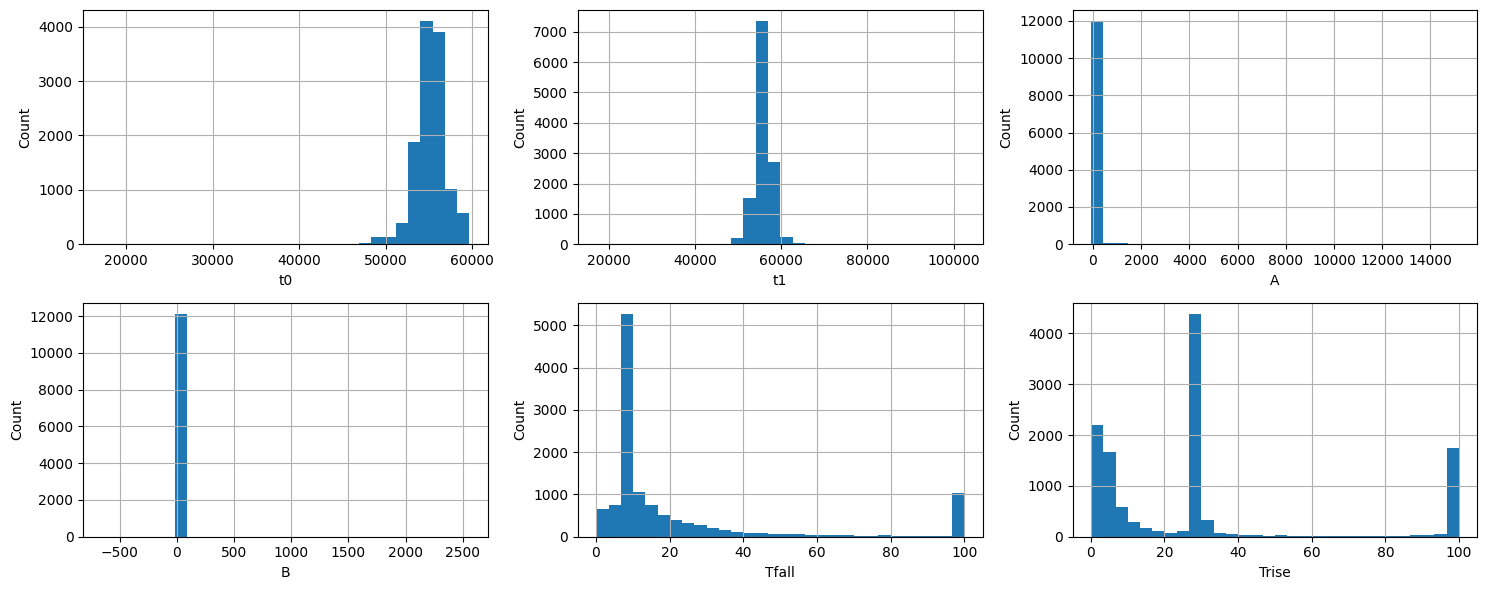

In [5]:
def histogram(df):
    cols = df.columns
    n = len(cols)
    rows = (n + 2) // 3    # number of rows needed
    fig, axes = plt.subplots(rows, 3, figsize=(15, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]
        df[column].hist(ax=ax, bins=30)
        #ax.set_title(column)
        ax.set_xlabel(column)
        ax.set_ylabel("Count")

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

histogram(X)

In [15]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=['IIn','II','Ia']):
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))
  '''
  if hasattr(model, "validation_scores_"):
    epochs = np.arange(1, len(model.loss_curve_)+1)

    fig, ax1 = plt.subplots(figsize=(10,6))

    # plot training loss on left y-axis
    ax1.plot(epochs, model.loss_curve_, color="tab:red", label="Training Loss", linewidth=2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # create a second axis for validation accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, model.validation_scores_, color="tab:blue", label="Validation Accuracy", linewidth=2)
    ax2.set_ylabel("Validation Accuracy", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylim([0.5,1])

    plt.title("MLP Training Loss and Validation Accuracy")
    fig.tight_layout()
    plt.show()
  '''

  # ---- ROC Curve ----
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

Attempt 1: Train SVM without handling outliers and scale data

In [7]:
# first split off test
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

In [ ]:
svm1 = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)
svm1.fit(X_train1, y_train1)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.6318709544847426

 Classification report:
                precision    recall  f1-score   support

           0       0.04      0.03      0.03       946
           1       0.04      0.49      0.08       221
           2       0.91      0.70      0.79      8566

    accuracy                           0.63      9733
   macro avg       0.33      0.41      0.30      9733
weighted avg       0.80      0.63      0.70      9733


 Confusion matrix:
 [[  28  403  515]
 [  13  109   99]
 [ 624 1929 6013]]

The test set:

 Validation accuracy:  0.6454396055875102

 Classification report:
                precision    recall  f1-score   support

           0       0.04      0.03      0.03       237
           1       0.05      0.53      0.09        55
           2       0.91      0.72      0.80      2142

    accuracy                           0.65      2434
   macro avg       0.33      0.42      0.31      2434
weighted avg       0.81      0.65      0.71 

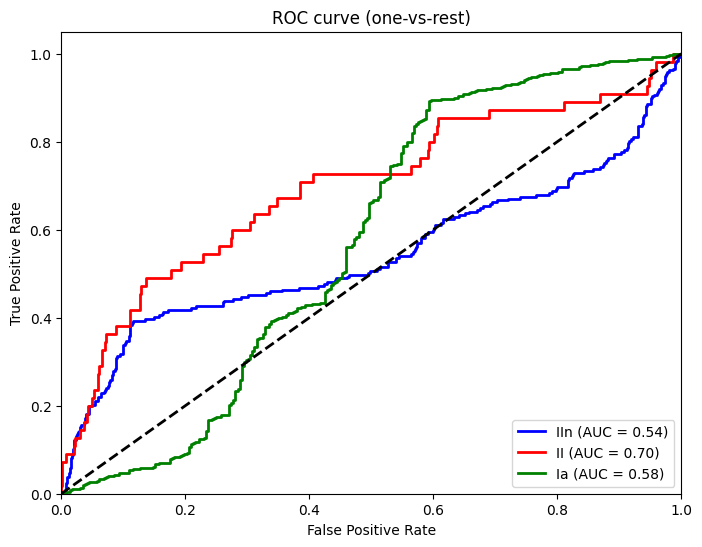

In [ ]:
evaluate_model(svm1, X_train1, y_train1, X_test1, y_test1)

Attempt 2: Train SVM with handling outliers and scale data

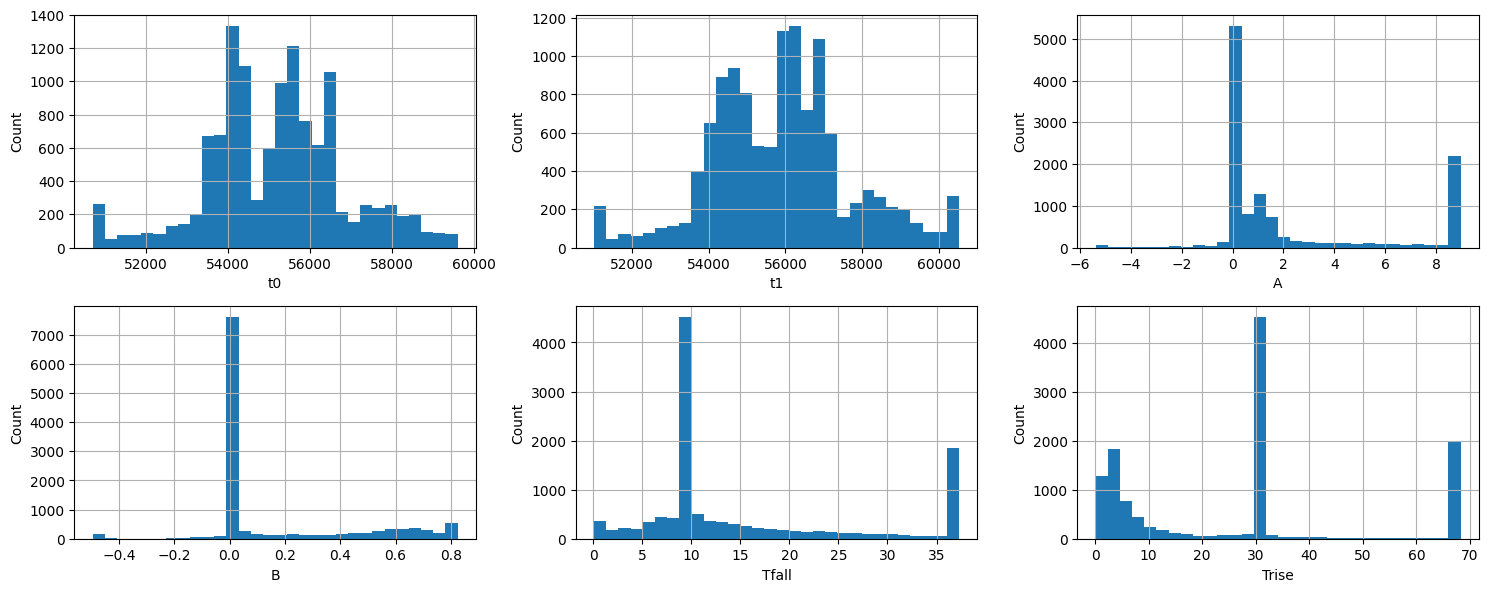

In [8]:
# Handling outliers
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_clipped = X.clip(lower=lower, upper=upper, axis=1)
histogram(X_clipped)

In [9]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

scaler = RobustScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [10]:
svm2 = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)
svm2.fit(X_train2, y_train2)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.7826980376040276

 Classification report:
                precision    recall  f1-score   support

           0       0.18      0.09      0.12       946
           1       0.08      0.39      0.13       221
           2       0.91      0.87      0.89      8566

    accuracy                           0.78      9733
   macro avg       0.39      0.45      0.38      9733
weighted avg       0.82      0.78      0.80      9733


 Confusion matrix:
 [[  83  237  626]
 [   8   86  127]
 [ 377  740 7449]]

The test set:

 Validation accuracy:  0.7752670501232539

 Classification report:
                precision    recall  f1-score   support

           0       0.18      0.09      0.12       237
           1       0.07      0.36      0.12        55
           2       0.90      0.86      0.88      2142

    accuracy                           0.78      2434
   macro avg       0.39      0.44      0.37      2434
weighted avg       0.82      0.78      0.79 

/tmp/ipython-input-4231010100.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


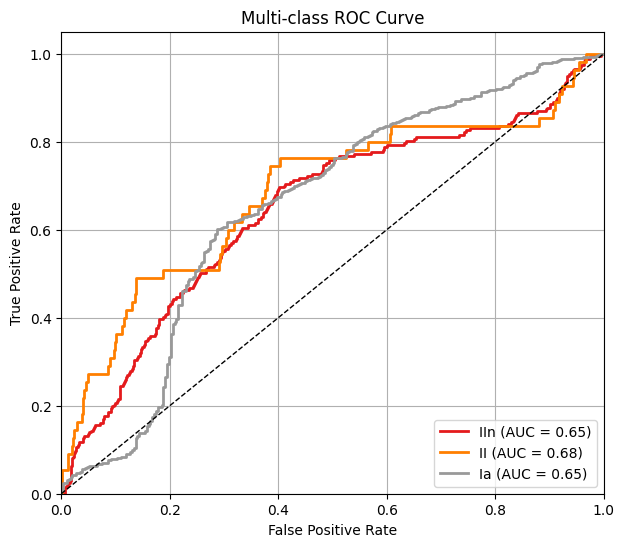

In [16]:
evaluate_model(svm2, X_train2, y_train2, X_test2, y_test2)

Attempt 3: Rebalance the dataset

In [ ]:
data['type'].value_counts()

,count
type,
Ia,10708
II,1183
IIn,276


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train3, y_train3 = smote.fit_resample(X_train2, y_train2)
print(pd.Series(y_train3).value_counts())

2    8566
0    8566
1    8566
Name: count, dtype: int64


In [ ]:
svm3 = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)
svm3.fit(X_train3, y_train3)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.4536928943886684

 Classification report:
                precision    recall  f1-score   support

           0       0.52      0.11      0.18      8566
           1       0.54      0.40      0.46      8566
           2       0.42      0.85      0.56      8566

    accuracy                           0.45     25698
   macro avg       0.49      0.45      0.40     25698
weighted avg       0.49      0.45      0.40     25698


 Confusion matrix:
 [[ 904 2181 5481]
 [ 356 3433 4777]
 [ 492  752 7322]]

The test set:

 Validation accuracy:  0.7686935086277732

 Classification report:
                precision    recall  f1-score   support

           0       0.17      0.10      0.13       237
           1       0.08      0.40      0.13        55
           2       0.91      0.85      0.88      2142

    accuracy                           0.77      2434
   macro avg       0.38      0.45      0.38      2434
weighted avg       0.82      0.77      0.79 

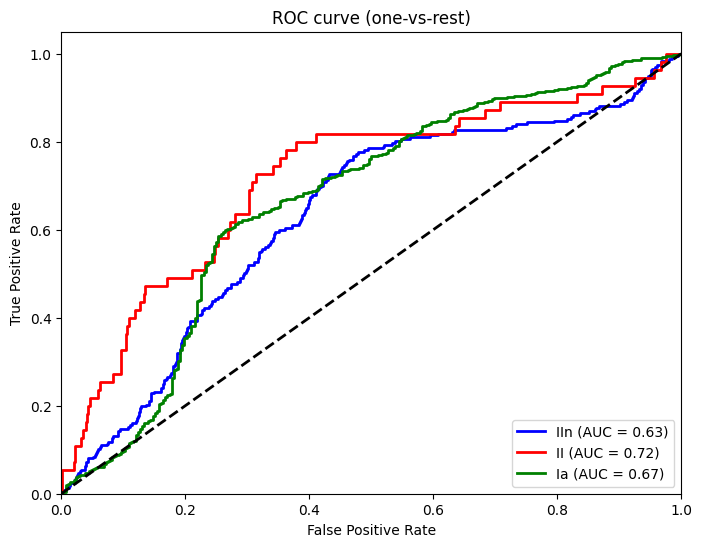

In [ ]:
evaluate_model(svm3, X_train3, y_train3, X_test2, y_test2)

Attempt 4: Using only certain filters

Unique mapped labels: [2 1 0]


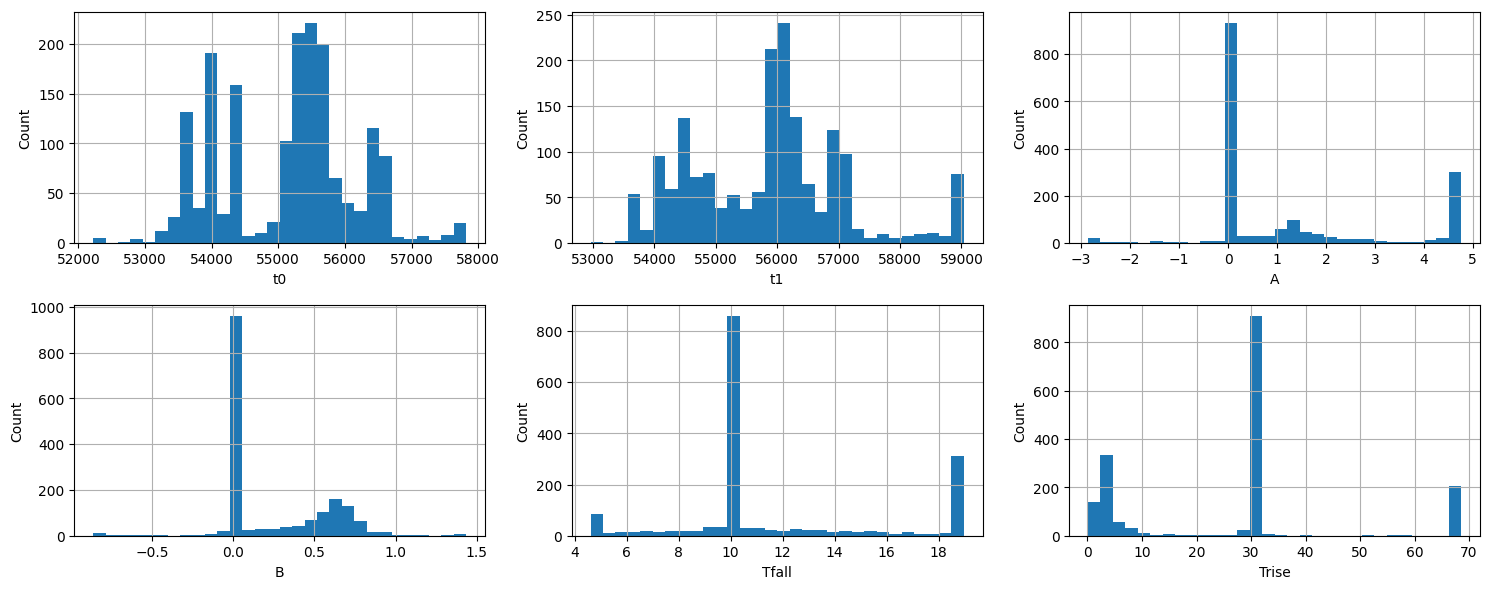

In [ ]:
# keep only some bands
bands = ["g", "g'"]
data_filter = data[data['band'].isin(bands)]

X_filter = data_filter[feature_cols]
y_filter = data_filter['type']

y_filter = y_filter.map({'IIn': 0, 'II': 1, 'Ia': 2})

# get mapping for checking
print("Unique mapped labels:", y_filter.unique())

# count examples in classes
pd.Series(y_filter).value_counts()

# handle outliers
Q1 = X_filter.quantile(0.25)
Q3 = X_filter.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_filter_clipped = X_filter.clip(lower=lower, upper=upper, axis=1)
histogram(X_filter_clipped)

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X_filter_clipped, y_filter,
    test_size=0.2,
    random_state=42,
    stratify=y_filter,
    shuffle=True
)

scaler = RobustScaler()
X_train4 = scaler.fit_transform(X_train4)
X_test4 = scaler.transform(X_test4)

In [ ]:
svm4 = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True)

svm4.fit(X_train4, y_train4)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.8166904422253923

 Classification report:
                precision    recall  f1-score   support

           0       0.21      0.90      0.35        10
           1       0.13      0.92      0.23        36
           2       1.00      0.81      0.90      1356

    accuracy                           0.82      1402
   macro avg       0.45      0.88      0.49      1402
weighted avg       0.97      0.82      0.88      1402


 Confusion matrix:
 [[   9    0    1]
 [   2   33    1]
 [  31  222 1103]]

The test set:

 Validation accuracy:  0.8062678062678063

 Classification report:
                precision    recall  f1-score   support

           0       0.12      0.50      0.20         2
           1       0.07      0.44      0.12         9
           2       0.98      0.82      0.89       340

    accuracy                           0.81       351
   macro avg       0.39      0.59      0.40       351
weighted avg       0.95      0.81      0.87 

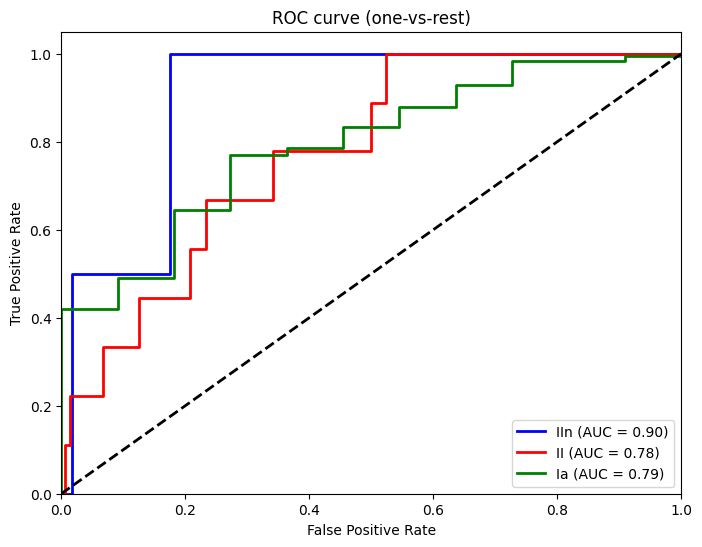

In [ ]:
evaluate_model(svm4, X_train4, y_train4, X_test4, y_test4)

Ateempt 5: Downsample Ia and merge II and IIn

In [17]:
Ia_down = Ia.sample(2000)

data_down = pd.concat([IIn, II, Ia_down], ignore_index=True)
data_down = data_down.sample(frac=1, random_state=42).reset_index(drop=True)

X_down = data_down[feature_cols]
y_down = data_down['type']

y_down = y_down.map({'IIn': 0, 'II': 1, 'Ia': 2})

# get mapping for checking
print("Unique mapped labels:", y_down.unique())

# count examples in classes
pd.Series(y_down).value_counts()

Unique mapped labels: [1 2 0]


,count
type,
2,2000
1,1183
0,276


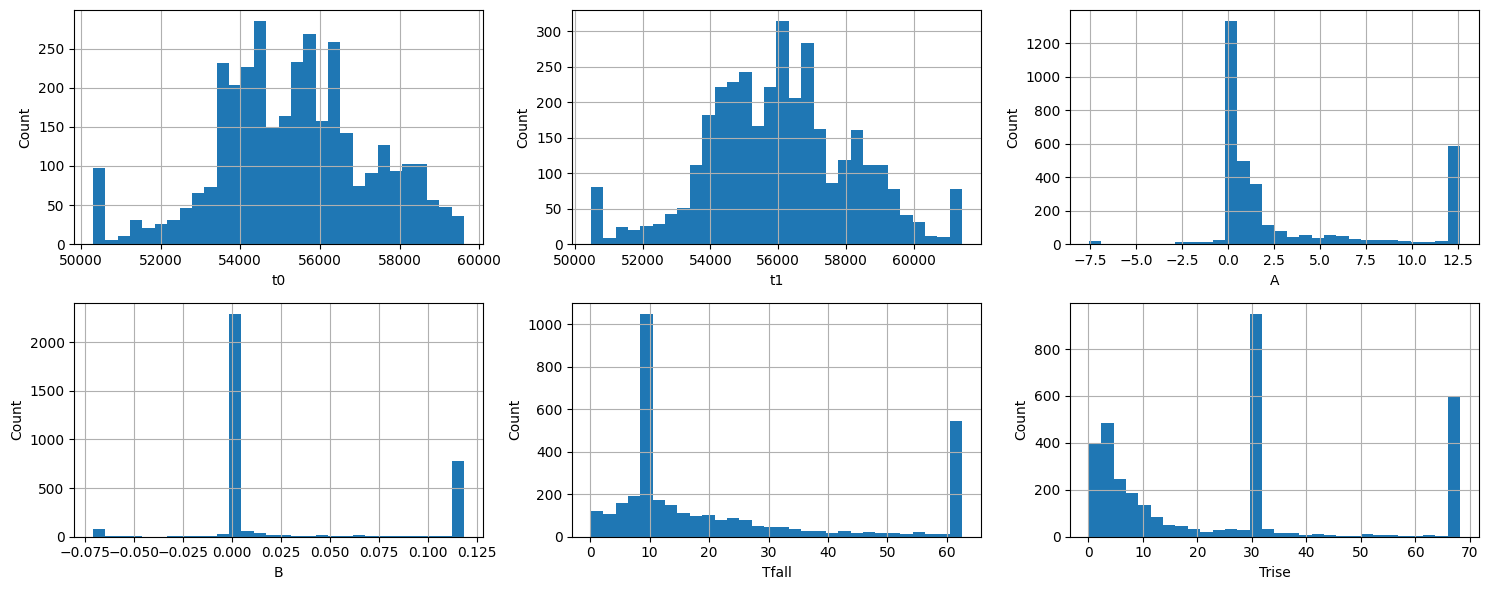

In [18]:
# handle outliers
Q1 = X_down.quantile(0.25)
Q3 = X_down.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_down = X_down.clip(lower=lower, upper=upper, axis=1)
histogram(X_down)

In [19]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X_down, y_down,
    test_size=0.2,
    random_state=42,
    stratify=y_down,
    shuffle=True
)

scaler = RobustScaler()
X_train5 = scaler.fit_transform(X_train5)
X_test5 = scaler.transform(X_test5)

In [20]:
svm5 = SVC(
    kernel='rbf',
    #degree=6,
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True)

svm5.fit(X_train5, y_train5)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.627394289844597

 Classification report:
                precision    recall  f1-score   support

           0       0.25      0.50      0.33       221
           1       0.53      0.58      0.55       946
           2       0.83      0.68      0.75      1600

    accuracy                           0.63      2767
   macro avg       0.54      0.58      0.54      2767
weighted avg       0.68      0.63      0.65      2767


 Confusion matrix:
 [[ 111   67   43]
 [ 229  544  173]
 [ 111  408 1081]]

The test set:

 Validation accuracy:  0.5953757225433526

 Classification report:
                precision    recall  f1-score   support

           0       0.17      0.38      0.23        55
           1       0.51      0.55      0.53       237
           2       0.84      0.65      0.74       400

    accuracy                           0.60       692
   macro avg       0.51      0.53      0.50       692
weighted avg       0.67      0.60      0.62  

/tmp/ipython-input-4231010100.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


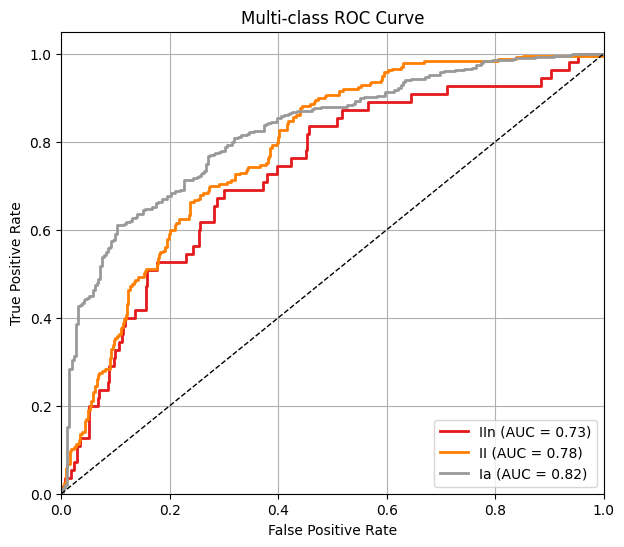

In [21]:
evaluate_model(svm5, X_train5, y_train5, X_test5, y_test5)